In [3]:
! pip install panphon

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 2.2 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10744 sha256=366eb2cd6787a62fb71a06f00a899c58d6f26fd3f5fe438f9b9db05c69e9619e
  Stored in directory: /root/.cache/pip/wheels/ec/03/6f/d2e0162d94c0d451556fa43dd4d5531457245c34a36b41ef4a
Successfully built unicodecsv


In [4]:
from typing import List, Tuple, Dict, Set, Callable, Union
import numpy as np
from panphon import FeatureTable, _panphon
import itertools
import pandas as pd

In [5]:
class Inventories:
    def __init__(self):
        self.ft = FeatureTable()
        self.timit_to_ipa, self.allophones_substitute, self.split_diphthongs_IPA, self.split_diphthongs_TIMIT = self._init_mappings()
        self.english_TIMIT = self._build_english_timit()
        self.english_ipa = self._build_english_inventory()
        self.yoruba_ipa = self._build_yoruba_inventory()
        self.distance_matrix = self._compute_distance_matrix()

    def _init_mappings(self) -> Tuple[Dict[str, str], Dict[str, str],
                                      Dict[str, List[str]], Dict[str, List[str]]]:
        timit_to_ipa = {
            # vowels
            "aa": "ɑ",      # father
            "ae": "æ",      # trap
            "ah": "ʌ",      # strut
            "ao": "ɔ",      # thought
            "aw": "aʊ",     # mouth
            "ay": "aɪ",     # price
            "ax": "ə",      # comma (schwa)
            "ax-h": "ə",    # aspirated schwa (treat as schwa)
            "axr": "ə\u02de",   # nurse (r-colored schwa)
            "eh": "ɛ",      # dress
            "er": "ɜ˞",      # bird (r-colored vowel)
            "ey": "eɪ",     # face
            "ih": "ɪ",      # kit
            "ix": "ɨ",      # high central unrounded (near-schwa)
            "iy": "i",      # fleece
            "ow": "oʊ",     # goat
            "oy": "ɔɪ",     # choice
            "uh": "ʊ",      # foot
            "uw": "u",      # goose
            "ux": "ʉ",      # dude
            # marginal allophones
            "ax-h": "ə̥",
            "bcl":  "b̚",
            "dcl":  "d̚",
            "eng":  "ŋ̍",
            "gcl":  "ɡ̚",
            "hv":   "ɦ",
            "kcl":  "k̚",
            "pcl":  "p̚",
            "tcl":  "t̚",
            # prosodic symbols
            "pau":  "|",
            "epi":  "||",
            "h#":   "/",
            # consonants
            "b":   "b",    # B
            "ch":  "t͡ʃ",   # CH
            "d":   "d",    # D
            "dh":  "ð",    # DH
            "dx":  "ɾ",    # DX
            "el":  "l̩",   # EL
            "em":  "m̩",   # EM
            "en":  "n̩",   # EN
            "f":   "f",    # F
            "g":   "ɡ",    # G
            "hh":  "h",    # HH
            "h":   "h",
            "jh":  "d͡ʒ",   # JH
            "k":   "k",    # K
            "l":   "l",    # L
            "m":   "m",    # M
            "n":   "n",    # N
            "nx":  "ŋ",    # NX
            "ng":  "ŋ",    # NG
            # "nx": "ɾ̃",
            "p":   "p",    # P
            "q":   "ʔ",    # Q
            "r":   "ɹ",    # R
            "s":   "s",    # S
            "sh":  "ʃ",    # SH
            "t":   "t",    # T
            "th":  "θ",    # TH
            "v":   "v",    # V
            "w":   "w",    # W
            "wh":  "ʍ",    # WH
            "y":   "j",    # Y
            "z":   "z",    # Z
            "zh":  "ʒ",    # ZH
        }
        # substitute the marginal sounds with close counterparts
        allophones_substitute = {
            "ax-h": "ə",
            "bcl":  "b",
            "dcl":  "d",
            "eng":  "ŋ",
            "gcl":  "ɡ",
            "hv":   "h",
            "kcl":  "k",
            "pcl":  "p",
            "tcl":  "t",
            "el":  "l",
            "em":  "m",
            "en":  "n",
            # "axr": "ɹ",
            # "er":  "ɹ"
        }
        split_diphthongs_IPA = {d: list(d) for d in ['aɪ', 'aʊ', 'eɪ', 'oʊ', 'ɔɪ']}
        split_diphthongs_TIMIT = {'oy': ['oh', 'y'],
                                  'ow': ['o', 'w'],
                                  'ay': ['a', 'y'],
                                  'aw': ['a', 'w'],
                                  'ey': ['e', 'y']}
        return timit_to_ipa, allophones_substitute, split_diphthongs_IPA, split_diphthongs_TIMIT

    def _build_english_inventory(self) -> set:
        timit_sub = self.timit_to_ipa.copy()
        for k, v in self.allophones_substitute.items():
            timit_sub[k] = v
        ipa = set(timit_sub.values()) - {'/', '|', '||'}
        delete_diphtongs = set(self.split_diphthongs_IPA.keys())
        add_monophthongs = set(itertools.chain(*self.split_diphthongs_IPA.values()))
        return (ipa | add_monophthongs) - delete_diphtongs

    def _build_english_timit(self) -> set:
        timit_sub = set(self.timit_to_ipa.keys())
        unnecessary_allophones = set(self.allophones_substitute.keys())
        timit_sub = timit_sub - {'pau', 'epi', 'h#'} - unnecessary_allophones
        delete_diphtongs = set(self.split_diphthongs_TIMIT.keys())
        add_monophthongs = set(itertools.chain(*self.split_diphthongs_TIMIT.values()))
        return (timit_sub | add_monophthongs) - delete_diphtongs

    def _build_yoruba_inventory(self) -> set:
        full = {'m', 'i', 'k', 'j', 'u', 'a', 'w', 'n', 't', 'l', 's', 'b', 'e',
              'o', 'ɡ', 'h', 'd', 'r', 'f', 'ɛ', 'ʃ', 'ɔ', 'd͡ʒ', '˦', '˨', 'ĩ',
              'ũ', 'ɡ͡b', 'k͡p', 'õ', 'ẽ', '˧', 'ŋ'}
        tones = {'˧', '˦', '˨'}
        marginal = {'õ', 'ẽ', 'ŋ'}
        return full - tones - marginal

    def _compute_distance_matrix(self) -> np.ndarray:
        matrix = pd.DataFrame(0.0, index=list(self.yoruba_ipa), columns=list(self.english_ipa))
        for y in self.yoruba_ipa:
            for e in self.english_ipa:
                matrix.loc[y, e] = compute_ipa_distance(y, e, self.ft)
        return matrix.sort_index().sort_index(axis=1)

    def find_closest(self, sound: str, lang: str='yoruba', k: int=1) -> List[str]:
        if lang.lower() == 'yoruba':
            return self.distance_matrix.loc[sound].nsmallest(k).index.tolist()
        elif lang.lower() == 'english':
            return self.distance_matrix[sound].nsmallest(k).index.tolist()
        else:
            raise ValueError('Language must be Yoruba or English.')


In [6]:
def ipa_to_vector(ipa: str, ft: FeatureTable) -> List[int]:
    """Convert a single IPA symbol into its binary feature vector via PanPhon."""
    features = ft.word_fts(ipa)
    if len(features) != 1:
        raise ValueError(f"the string {ipa} is not a phone")
    return features[0].numeric()

In [7]:
def compute_vector_distance(v1: List[int], v2: List[int]) -> float:
    """Compute normalized absolute feature distance between two vectors of
    dimension overall number of features in PanPhon and values {-1, 1, 0}."""
    arr1 = np.array(v1)
    arr2 = np.array(v2)
    return round(np.sum(np.abs(arr1 - arr2)) / len(arr1), 4)

In [8]:
def compute_ipa_distance(ipa1: str, ipa2: str, ft: FeatureTable) -> float:
    """Compute feature-based distance between two IPA symbols."""
    vec1 = ipa_to_vector(ipa1, ft)
    vec2 = ipa_to_vector(ipa2, ft)
    return compute_vector_distance(vec1, vec2)

In [9]:
def compute_distance_matrix(source_set: Set[str], target_set: Set[str],
                            ft: FeatureTable) -> Dict[Tuple[str, str], float]:
    """Generate a mapping of distances between source and target phoneme sets."""
    return {
        (src, tgt): compute_ipa_distance(src, tgt, ft)
        for src in sorted(source_set)
        for tgt in sorted(target_set)
    }

In [10]:
### COMPUTING STRING DISTANCE

In [11]:
def feature_vectorize(ipa: str, ft: FeatureTable) -> np.ndarray:
    """
    vectorize the whole IPA string
    """
    vecs = ft.word_fts(ipa)
    if not vecs:
        raise ValueError(f"IPA '{ipa}' could not be parsed")
    return np.array([v.numeric() for v in vecs])

def ipa_segments(ipa: str, ft: FeatureTable) -> List[str]:
    return ft.ipa_segs(ipa)

# for levesntein, can be modified
def substitution_cost(v1: np.ndarray, v2: np.ndarray) -> float:
    return round(np.sum(np.abs(v1 - v2)) / len(v1), 4)

def deletion_cost(_: np.ndarray) -> float:
    return 1.0

def insertion_cost(_: np.ndarray) -> float:
    return 1.0

def compute_alignment_matrix(
    source: np.ndarray,
    target: np.ndarray,
    del_cost: Callable,
    ins_cost: Callable,
    sub_cost: Callable
) -> Tuple[np.ndarray, float, np.ndarray]:
    # make levenstein matrix and initialise fist row and column
    n, m = len(source), len(target)
    D = np.zeros((n + 1, m + 1))  # distances
    O = np.full((n + 1, m + 1), "", dtype=object)  # operations
    O[0, 0] = "begin"
    for i in range(1, n + 1):
        D[i, 0] = D[i - 1, 0] + del_cost(source[i - 1])
        O[i, 0] = 'del'
    for j in range(1, m + 1):
        D[0, j] = D[0, j - 1] + ins_cost(target[j - 1])
        O[0, j] = 'ins'
    # fill in
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            costs = {
                'sub': D[i - 1, j - 1] + sub_cost(source[i - 1], target[j - 1]),
                'del': D[i - 1, j]     + del_cost(source[i - 1]),
                'ins': D[i, j - 1]     + ins_cost(target[j - 1])
            }
            best_operation = min(costs, key=costs.get)
            D[i, j] = costs[best_operation]
            O[i, j] = best_operation
    return D, D[n, m], O

def trace_alignment(operations: np.ndarray, source: List[str],
                    target: List[str]) -> List[Tuple[str, str]]:
    i, j = len(source), len(target)
    alignment = []
    while i > 0 or j > 0:
        operation = operations[i, j]
        if operation == 'sub':
            alignment.append((source[i - 1], target[j - 1]))
            i -= 1
            j -= 1
        elif operation == 'del':
            alignment.append((source[i - 1], "ε"))
            i -= 1
        elif operation == 'ins':
            alignment.append(("ε", target[j - 1]))
            j -= 1
        elif operation == 'begin':
            break
        else:
            raise RuntimeError(f"Indices didn't align")
    return alignment[::-1]

In [12]:
# CONFUSION MATRIX
def feature_edit_alignment(
    ipa1: str,
    ipa2: str,
    ft: FeatureTable
) -> Tuple[List[Tuple[str, str, str]], float]:
    phonemes1 = ipa_segments(ipa1, ft)
    phonemes2 = ipa_segments(ipa2, ft)
    vectors1 = feature_vectorize(ipa1, ft)
    vectors2 = feature_vectorize(ipa2, ft)
    D, lev_distance, O = compute_alignment_matrix(vectors1, vectors2, deletion_cost, insertion_cost, substitution_cost)
    alignment = trace_alignment(O, phonemes1, phonemes2)
    return alignment, lev_distance

def phoneme_error_rate(sentences1: List[str], sentences2: List[str], ft: FeatureTable) -> float:
    """
    basically expected feature levenstein between two sets
    """
    assert len(sentences1) == len(sentences2), "two lists don't align"
    assert sentences1 and sentences2, "some list is empty"
    sum_edits = 0
    sum_phonemes = 0
    for s1, s2 in zip(sentences1, sentences2):
        phonemes1 = ipa_segments(s1, ft)
        phonemes2 = ipa_segments(s2, ft)
        vectors1 = feature_vectorize(s1, ft)
        vectors2 = feature_vectorize(s2, ft)
        _, dist, _ = compute_alignment_matrix(vectors1, vectors2, deletion_cost, insertion_cost, substitution_cost)
        sum_edits += dist
        sum_phonemes += max(len(phonemes1), len(phonemes2))
    return sum_edits / sum_phonemes

def make_confusion_matrix(predicted_sents: List[str], golden_sents: List[str], ft: FeatureTable) -> pd.DataFrame:
    assert len(predicted_sents) == len(golden_sents), "two lists don't align"
    assert predicted_sents and golden_sents, "some list is empty"
    alignments = []
    for p, g in zip(predicted_sents, golden_sents):
        alignment = feature_edit_alignment(p, g, ft)[0]
        alignments.extend(alignment)
    inventory_pred, inventory_gold = set([p for p, g in alignments]), set([g for p, g in alignments])
    coocurrences = pd.DataFrame(0, index=list(inventory_pred), columns=list(inventory_gold))
    for src, tgt in alignments:
        coocurrences.loc[src, tgt] += 1
    confusions = coocurrences.div(coocurrences.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
    return (confusions * 100).round(1)

In [13]:
### DEMO

In [14]:
i = Inventories()

In [15]:
i.distance_matrix

,a,b,d,d͡ʒ,e,f,h,i,j,k,...,ɹ,ɾ,ʃ,ʉ,ʊ,ʌ,ʍ,ʒ,ʔ,θ
a,0.0000,0.6667,0.7083,0.8750,0.1667,0.7500,0.4167,0.2500,0.4167,0.6667,...,0.6250,0.5833,0.7917,0.3750,0.3333,0.0833,0.5833,0.7083,0.5000,0.7083
b,0.6667,0.0000,0.2083,0.4583,0.5000,0.2500,0.5000,0.5833,0.5000,0.4167,...,0.6250,0.5000,0.5417,0.7083,0.7500,0.5833,0.6667,0.4583,0.5833,0.3750
d,0.7083,0.2083,0.0000,0.3333,0.5417,0.4583,0.5417,0.6250,0.5417,0.4583,...,0.4167,0.2917,0.4167,0.9167,0.7917,0.6250,0.8750,0.3333,0.6250,0.2500
d͡ʒ,0.8750,0.4583,0.3333,0.0000,0.7083,0.5417,0.6250,0.7917,0.6250,0.5417,...,0.7500,0.5417,0.2500,1.0000,0.9583,0.7917,0.9583,0.1667,0.7083,0.4167
e,0.1667,0.5000,0.5417,0.7083,0.0000,0.5833,0.4167,0.0833,0.2500,0.6667,...,0.4583,0.5000,0.6250,0.3750,0.3333,0.0833,0.5833,0.5417,0.5000,0.5417
f,0.7500,0.2500,0.4583,0.5417,0.5833,0.0000,0.4167,0.6667,0.5833,0.5000,...,0.7083,0.5833,0.2917,0.7917,0.8333,0.6667,0.5833,0.3750,0.6667,0.2917
h,0.4167,0.5000,0.5417,0.6250,0.4167,0.4167,0.0000,0.5000,0.3333,0.2500,...,0.6250,0.5000,0.3750,0.6250,0.5000,0.3333,0.3333,0.4583,0.2500,0.3750
i,0.2500,0.5833,0.6250,0.7917,0.0833,0.6667,0.5000,0.0000,0.1667,0.5833,...,0.3750,0.5000,0.7083,0.2917,0.2500,0.1667,0.5000,0.6250,0.5833,0.6250
ĩ,0.3333,0.6667,0.7083,0.8750,0.1667,0.7500,0.5833,0.0833,0.2500,0.6667,...,0.4583,0.5833,0.7917,0.3750,0.3333,0.2500,0.5833,0.7083,0.6667,0.7083
j,0.4167,0.5000,0.5417,0.6250,0.2500,0.5833,0.3333,0.1667,0.0000,0.4167,...,0.2917,0.4167,0.5417,0.4583,0.3333,0.3333,0.3333,0.4583,0.4167,0.5417


In [16]:
i.find_closest('ɔ', lang='english', k=3)

['ɔ', 'o', 'ɛ']

In [17]:
i.find_closest('k͡p', lang='yoruba', k=3)

['k', 'p', 'ɡ']

In [18]:
ft = FeatureTable()
examples = [
    ('ed͡ʒi', 'ɛd͡ʒi'),
    ('ki nĩ a mũ wa aje', 'kilæ mua jɪ')
]

for yo, eng in examples:
    alignment, score = feature_edit_alignment(eng, yo, ft)
    print(f"\n{eng} vs. {yo} — Distance: {round(score, 2)}")
    for src, tgt in alignment:
        print(f"{src:5} → {tgt:5}")

# Error rates
list_eng = ['kilæ mua jɪ', 'ɛd͡ʒi']
list_yor = ['ki nĩ a mũ wa aje', 'ed͡ʒi']

print(f"\nPhoneme error rate: {round(phoneme_error_rate(list_eng, list_yor, ft), 3)}")


ɛd͡ʒi vs. ed͡ʒi — Distance: 0.08
ɛ     → e    
d͡ʒ   → d͡ʒ  
i     → i    

kilæ mua jɪ vs. ki nĩ a mũ wa aje — Distance: 3.58
k     → k    
i     → i    
l     → n    
ε     → ĩ   
æ     → a    
m     → m    
u     → ũ   
ε     → w    
ε     → a    
a     → a    
j     → j    
ɪ     → e    

Phoneme error rate: 0.244


In [19]:
make_confusion_matrix(list_eng, list_yor, ft)

,i,e,m,ũ,d͡ʒ,k,a,ĩ,j,n,w
ε,0.0,0.0,0.0,0.0,0.0,0.0,33.3,100.0,0.0,0.0,100.0
u,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ɪ,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
m,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
æ,0.0,0.0,0.0,0.0,0.0,0.0,33.3,0.0,0.0,0.0,0.0
d͡ʒ,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
k,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
a,0.0,0.0,0.0,0.0,0.0,0.0,33.3,0.0,0.0,0.0,0.0


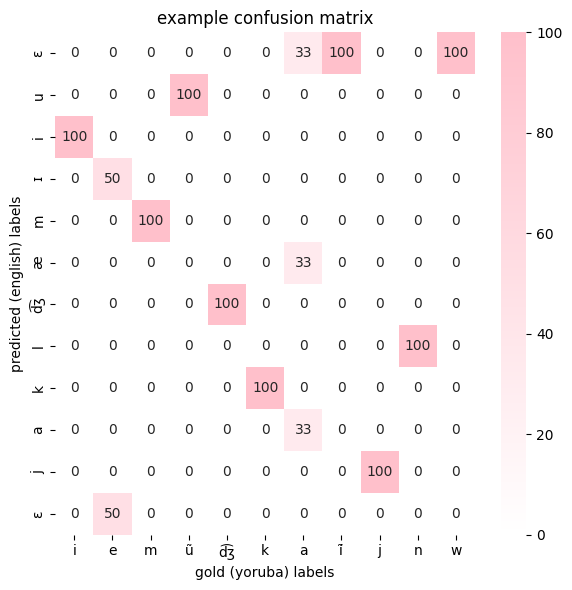

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = LinearSegmentedColormap.from_list("white_to_pink", ["#ffffff", "#ffc0cb"])

ill, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(make_confusion_matrix(list_eng, list_yor, ft).round(0), annot=True,
            fmt=".0f", cmap=colors, ax=ax)

ax.set_xlabel("gold (yoruba) labels")
ax.set_ylabel("predicted (english) labels")
ax.set_title("example confusion matrix")

plt.tight_layout()
plt.show()